# Untrained BERT Legal Violation Classifier — Top-8 Articles (20M Parameters)

### Model Configuration
| Parameter | Value |
|-----------|-------|
| **Architecture** | Untrained BERT (from scratch) |
| **Parameters** | ~20M params |
| **Hidden size** | 384 |
| **Layers** | 6 |
| **Attention heads** | 12 |
| **Intermediate size** | 1536 |
| **Dropout** | 0.3 |
| **Epochs** | 6 |
| **Early stopping** | Stop if val loss doesn't improve for 2 epochs |
| **Label smoothing** | 0.05 |

Model size: **~20M params**  
Training: **From scratch on legal violation data**

In [ ]:
%pip install -q transformers>=4.40.0 scikit-learn tqdm matplotlib seaborn

In [ ]:
import os, json, zipfile, shutil, random, math, time, warnings
from pathlib import Path
from collections import Counter
from dataclasses import dataclass
from typing import Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast
from transformers import AutoTokenizer, BertConfig
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    props = torch.cuda.get_device_properties(0)
    VRAM  = props.total_memory / 1e9
    print(f"GPU  : {props.name}  ({VRAM:.1f} GB)")
else:
    VRAM = 0
    print("Warning: CPU only")
print(f"Device : {DEVICE}  |  PyTorch {torch.__version__}")

✓ GPU  : Tesla T4  (15.6 GB)
✓ Device : cuda  |  PyTorch 2.9.0+cu128


## Section 1 — Data (Top-8 Labels)

In [ ]:
DATA_ROOT = Path("./ecthr_data")
if DATA_ROOT.exists():
    shutil.rmtree(DATA_ROOT)
DATA_ROOT.mkdir()

# Place your dataset zip at the path below, or extract manually
ZIP_PATH = "./dataset.zip"
with zipfile.ZipFile(ZIP_PATH, "r") as zf:
    zf.extractall(DATA_ROOT)
print(f"Extracted to {DATA_ROOT}")

In [ ]:
import pandas as pd

def find_files(root, patterns):
    found = []
    for pat in patterns:
        found.extend(root.rglob(pat))
    return sorted(found)

jsonl_files   = find_files(DATA_ROOT, ["*.jsonl", "*.json"])
parquet_files = find_files(DATA_ROOT, ["*.parquet"])

def load_jsonl(path):
    rows = []
    with open(path, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                rows.append(json.loads(line))
    return rows

def load_split(keywords):
    for kw in keywords:
        for f in jsonl_files:
            if kw in f.name.lower():
                print(f"  JSONL  -> {f.name}")
                return load_jsonl(f)
        for f in parquet_files:
            if kw in f.name.lower():
                print(f"  Parquet -> {f.name}")
                return pd.read_parquet(f).to_dict("records")
    return []

print("Loading splits ...")
raw_train = load_split(["train"])
raw_val   = load_split(["dev", "val", "valid", "validation"])
raw_test  = load_split(["test"])

print(f"Counts -> train={len(raw_train):,}  val={len(raw_val):,}  test={len(raw_test):,}")

Loading splits …
  JSONL  → train.jsonl
  JSONL  → dev.jsonl
  JSONL  → test.jsonl
Counts → train=9,000  val=1,000  test=1,000


In [ ]:
def get_articles(rec):
    for key in ("violated_articles", "labels", "violated_provisions",
                "gold_labels", "silver_rationales"):
        val = rec.get(key)
        if val is not None:
            if isinstance(val, list):
                return [str(v).strip() for v in val if v is not None and str(v).strip()]
            if isinstance(val, str) and val.strip():
                return [val.strip()]
    return []

def get_text(rec):
    for key in ("facts", "text", "case_text", "content"):
        val = rec.get(key)
        if val is not None:
            if isinstance(val, list): return " ".join(str(v) for v in val if v)
            return str(val)
    parts = [str(v) for v in rec.values() if isinstance(v, str) and len(v) > 30]
    return " ".join(parts)

# Count all labels
all_labels_raw = []
for rec in raw_train:
    all_labels_raw.extend(get_articles(rec))

label_counts = Counter(all_labels_raw)

TOP_K      = 8
top_labels = [lbl for lbl, cnt in label_counts.most_common(TOP_K)]
top_labels.sort()    # alphabetical order for consistency

NUM_LABELS = len(top_labels)
label2idx  = {lbl: i for i, lbl in enumerate(top_labels)}
idx2label  = {i: lbl for lbl, i in label2idx.items()}

print(f"Using TOP-{TOP_K} most frequent articles:")
for lbl in top_labels:
    cnt = label_counts[lbl]
    print(f"  Article {lbl:<10s}  {cnt:>5,}  ({100*cnt/len(raw_train):.1f}%)")

print(f"\nLabel map: {label2idx}")

Using TOP-8 most frequent articles:
  Article 10            291  (3.2%)
  Article 13          1,238  (13.8%)
  Article 2             505  (5.6%)
  Article 3           1,349  (15.0%)
  Article 5           1,368  (15.2%)
  Article 6           4,704  (52.3%)
  Article 8             710  (7.9%)
  Article P1-1        1,421  (15.8%)

Label map: {'10': 0, '13': 1, '2': 2, '3': 3, '5': 4, '6': 5, '8': 6, 'P1-1': 7}


## Section 2 — Tokenizer

In [ ]:
TOKENIZER_NAME = "bert-base-uncased"
MAX_SEQ_LEN    = 512

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)
print(f"Tokenizer : {TOKENIZER_NAME}")
print(f"Vocab     : {tokenizer.vocab_size:,}")
print(f"Max len   : {MAX_SEQ_LEN}")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizer : bert-base-uncased
Vocab     : 30,522
Max len   : 512


## Section 3 — Dataset (Top-8 Filter + Label Smoothing)

In [ ]:
LABEL_SMOOTHING = 0.05   # soft targets: 0->0.05, 1->0.95

def encode_labels(articles, smoothing=LABEL_SMOOTHING):
    vec = [smoothing] * NUM_LABELS   # negative class -> 0.05
    for art in articles:
        if art in label2idx:
            vec[label2idx[art]] = 1.0 - smoothing   # positive class -> 0.95
    return vec

def process_records(records, split_name=""):
    texts, labels = [], []
    skipped_no_top8 = 0
    skipped_empty   = 0
    for rec in records:
        t = get_text(rec)
        arts = get_articles(rec)

        # Check if ANY of the top-8 labels are present
        has_top8 = any(art in label2idx for art in arts)

        if not has_top8:
            skipped_no_top8 += 1
            continue
        if len(t.strip()) < 20:
            skipped_empty += 1
            continue

        l = encode_labels(arts)
        texts.append(t)
        labels.append(l)

    if split_name:
        print(f"  {split_name}: {len(texts):,} kept  |  "
              f"skipped: {skipped_no_top8} (no top-8), {skipped_empty} (empty text)")
    return texts, labels

print("Processing (filtering to examples with at least 1 top-8 label) ...")
train_texts, train_labels = process_records(raw_train, "train")
val_texts,   val_labels   = process_records(raw_val,   "val")
test_texts,  test_labels  = process_records(raw_test,  "test")

# Stats
sample_lens = [len(tokenizer(t, truncation=False)["input_ids"]) for t in train_texts[:500]]
print(f"\nToken lengths (500 samples): mean={np.mean(sample_lens):.0f}  "
      f"p95={np.percentile(sample_lens,95):.0f}")

class ECHRDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts, self.labels, self.tokenizer, self.max_len = texts, labels, tokenizer, max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tokenizer(self.texts[idx], max_length=self.max_len,
                            padding="max_length", truncation=True, return_tensors="pt")
        return {
            "input_ids"     : enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels"        : torch.tensor(self.labels[idx], dtype=torch.float),
        }

BATCH_SIZE = 16 if VRAM >= 12 else 8

train_loader = DataLoader(ECHRDataset(train_texts, train_labels, tokenizer, MAX_SEQ_LEN),
                          batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(ECHRDataset(val_texts,   val_labels,   tokenizer, MAX_SEQ_LEN),
                          batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(ECHRDataset(test_texts,  test_labels,  tokenizer, MAX_SEQ_LEN),
                          batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"DataLoaders (batch={BATCH_SIZE}): train={len(train_loader)} | "
      f"val={len(val_loader)} | test={len(test_loader)}")

Token indices sequence length is longer than the specified maximum sequence length for this model (8507 > 512). Running this sequence through the model will result in indexing errors


Processing (filtering to examples with at least 1 top-8 label) …
  train: 8,019 kept  |  skipped: 981 (no top-8), 0 (empty text)
  val: 817 kept  |  skipped: 183 (no top-8), 0 (empty text)
  test: 828 kept  |  skipped: 172 (no top-8), 0 (empty text)

Token lengths (500 samples): mean=1715  p95=5358
DataLoaders (batch=16): train=502 | val=52 | test=52


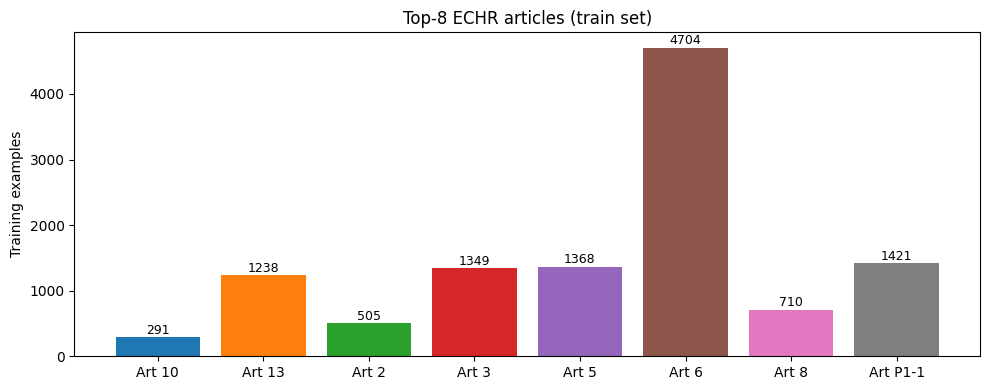

In [ ]:
# Undo label smoothing for counting
label_freq_arr = (np.array(train_labels) > 0.5).astype(int).sum(0)

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(range(NUM_LABELS), label_freq_arr, color=plt.cm.tab10(np.arange(NUM_LABELS)))
ax.set_xticks(range(NUM_LABELS))
ax.set_xticklabels([f"Art {top_labels[i]}" for i in range(NUM_LABELS)], fontsize=10)
ax.set_ylabel("Training examples")
ax.set_title(f"Top-{NUM_LABELS} ECHR articles (train set)")
for i, v in enumerate(label_freq_arr):
    ax.text(i, v + 50, f"{int(v)}", ha="center", fontsize=9)
plt.tight_layout()
plt.savefig("./label_dist.png", dpi=120, bbox_inches="tight")
plt.show()

## Section 4 — Untrained BERT Architecture (20M Parameters)

**Custom BERT configuration for ~20M params:**
- Hidden size: **384**
- Layers: **6**
- Attention heads: **12**
- Intermediate size: **1536**
- Dropout: **0.3**
- Trained from scratch (no pretrained weights)

In [ ]:
class BertEmbeddings(nn.Module):
    """BERT-style embeddings: token + position + type"""
    def __init__(self, vocab_size, hidden_size, max_position_embeddings, dropout):
        super().__init__()
        self.word_embeddings = nn.Embedding(vocab_size, hidden_size, padding_idx=0)
        self.position_embeddings = nn.Embedding(max_position_embeddings, hidden_size)
        self.token_type_embeddings = nn.Embedding(2, hidden_size)
        self.LayerNorm = nn.LayerNorm(hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(dropout)
        # Initialize position IDs
        self.register_buffer("position_ids",
                           torch.arange(max_position_embeddings).expand((1, -1)))

    def forward(self, input_ids):
        B, T = input_ids.shape
        position_ids = self.position_ids[:, :T]
        token_type_ids = torch.zeros_like(input_ids)

        embeddings = self.word_embeddings(input_ids)
        embeddings += self.position_embeddings(position_ids)
        embeddings += self.token_type_embeddings(token_type_ids)
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

class BertSelfAttention(nn.Module):
    """Multi-head self-attention"""
    def __init__(self, hidden_size, num_attention_heads, dropout):
        super().__init__()
        assert hidden_size % num_attention_heads == 0
        self.num_attention_heads = num_attention_heads
        self.attention_head_size = hidden_size // num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(hidden_size, self.all_head_size)
        self.key = nn.Linear(hidden_size, self.all_head_size)
        self.value = nn.Linear(hidden_size, self.all_head_size)
        self.dropout = nn.Dropout(dropout)

    def transpose_for_scores(self, x):
        new_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(new_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, attention_mask=None):
        query_layer = self.transpose_for_scores(self.query(hidden_states))
        key_layer = self.transpose_for_scores(self.key(hidden_states))
        value_layer = self.transpose_for_scores(self.value(hidden_states))

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask

        attention_probs = F.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_shape)
        return context_layer

class BertSelfOutput(nn.Module):
    """Add & Norm after self-attention"""
    def __init__(self, hidden_size, dropout):
        super().__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.LayerNorm = nn.LayerNorm(hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(dropout)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

class BertAttention(nn.Module):
    """Self-attention + output projection"""
    def __init__(self, hidden_size, num_attention_heads, dropout):
        super().__init__()
        self.self_attn = BertSelfAttention(hidden_size, num_attention_heads, dropout)
        self.output = BertSelfOutput(hidden_size, dropout)

    def forward(self, hidden_states, attention_mask=None):
        self_outputs = self.self_attn(hidden_states, attention_mask)
        attention_output = self.output(self_outputs, hidden_states)
        return attention_output

class BertIntermediate(nn.Module):
    """First half of feed-forward network"""
    def __init__(self, hidden_size, intermediate_size):
        super().__init__()
        self.dense = nn.Linear(hidden_size, intermediate_size)

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = F.gelu(hidden_states)
        return hidden_states

class BertOutput(nn.Module):
    """Second half of FFN + Add & Norm"""
    def __init__(self, intermediate_size, hidden_size, dropout):
        super().__init__()
        self.dense = nn.Linear(intermediate_size, hidden_size)
        self.LayerNorm = nn.LayerNorm(hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(dropout)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

class BertLayer(nn.Module):
    """Single BERT transformer layer"""
    def __init__(self, hidden_size, num_attention_heads, intermediate_size, dropout):
        super().__init__()
        self.attention = BertAttention(hidden_size, num_attention_heads, dropout)
        self.intermediate = BertIntermediate(hidden_size, intermediate_size)
        self.output = BertOutput(intermediate_size, hidden_size, dropout)

    def forward(self, hidden_states, attention_mask=None):
        attention_output = self.attention(hidden_states, attention_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output

class BertEncoder(nn.Module):
    """Stack of BERT layers"""
    def __init__(self, num_hidden_layers, hidden_size, num_attention_heads,
                 intermediate_size, dropout):
        super().__init__()
        self.layers = nn.ModuleList([
            BertLayer(hidden_size, num_attention_heads, intermediate_size, dropout)
            for _ in range(num_hidden_layers)
        ])

    def forward(self, hidden_states, attention_mask=None):
        for layer in self.layers:
            hidden_states = layer(hidden_states, attention_mask)
        return hidden_states

class BertPooler(nn.Module):
    """Pool [CLS] token"""
    def __init__(self, hidden_size):
        super().__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # Take [CLS] token (first token)
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

class UntrainedBertForClassification(nn.Module):
    """BERT model trained from scratch for multi-label classification"""
    def __init__(self, vocab_size, hidden_size, num_hidden_layers, num_attention_heads,
                 intermediate_size, max_position_embeddings, num_labels, dropout):
        super().__init__()
        self.embeddings = BertEmbeddings(vocab_size, hidden_size,
                                        max_position_embeddings, dropout)
        self.encoder = BertEncoder(num_hidden_layers, hidden_size, num_attention_heads,
                                  intermediate_size, dropout)
        self.pooler = BertPooler(hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_size, num_labels)

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """Initialize weights like BERT"""
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, input_ids, attention_mask=None):
        # Create attention mask in correct format
        extended_attention_mask = None
        if attention_mask is not None:
            extended_attention_mask = attention_mask[:, None, None, :]
            extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        embedding_output = self.embeddings(input_ids)
        encoder_output = self.encoder(embedding_output, extended_attention_mask)
        pooled_output = self.pooler(encoder_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

    def count_parameters(self):
        total = trainable = 0
        for p in self.parameters():
            total += p.numel()
            if p.requires_grad: trainable += p.numel()
        return total, trainable

In [ ]:
# Configuration for ~20M parameters
HIDDEN_SIZE = 384
NUM_HIDDEN_LAYERS = 6
NUM_ATTENTION_HEADS = 12
INTERMEDIATE_SIZE = 1536
MAX_POSITION_EMBEDDINGS = 512
DROPOUT = 0.3

model = UntrainedBertForClassification(
    vocab_size=tokenizer.vocab_size,
    hidden_size=HIDDEN_SIZE,
    num_hidden_layers=NUM_HIDDEN_LAYERS,
    num_attention_heads=NUM_ATTENTION_HEADS,
    intermediate_size=INTERMEDIATE_SIZE,
    max_position_embeddings=MAX_POSITION_EMBEDDINGS,
    num_labels=NUM_LABELS,
    dropout=DROPOUT
).to(DEVICE)

total_p, train_p = model.count_parameters()

print("=" * 60)
print("UNTRAINED BERT CLASSIFIER — 20M PARAMETERS")
print("=" * 60)
print(f"  Hidden size      : {HIDDEN_SIZE}")
print(f"  Layers           : {NUM_HIDDEN_LAYERS}")
print(f"  Attention heads  : {NUM_ATTENTION_HEADS}")
print(f"  Intermediate     : {INTERMEDIATE_SIZE}")
print(f"  Dropout          : {DROPOUT}")
print(f"  Vocab            : {tokenizer.vocab_size:,}")
print(f"  Labels           : {NUM_LABELS}")
print("-" * 60)
print(f"  Total params     : {total_p:>12,}  ({total_p/1e6:.2f} M)")
print("=" * 60)

dummy = torch.zeros(2, 16, dtype=torch.long, device=DEVICE)
mask  = torch.ones(2, 16, dtype=torch.long, device=DEVICE)
with torch.no_grad():
    out = model(dummy, mask)
print(f"  Forward -> {tuple(out.shape)}")
assert not torch.isnan(out).any()
print(f"  NaN check -> clean")
print("=" * 60)

════════════════════════════════════════════════════════════
UNTRAINED BERT CLASSIFIER — 20M PARAMETERS
════════════════════════════════════════════════════════════
  Hidden size      : 384
  Layers           : 6
  Attention heads  : 12
  Intermediate     : 1536
  Dropout          : 0.3
  Vocab            : 30,522
  Labels           : 8
────────────────────────────────────────────────────────────
  Total params     :   22,716,296  (22.72 M)
════════════════════════════════════════════════════════════
  Forward → (2, 8)  ✓
  NaN check → clean  ✓
════════════════════════════════════════════════════════════


## Section 5 — Training (Regularized)

In [ ]:
# No pos_weight — label smoothing already handles imbalance
criterion = nn.BCEWithLogitsLoss(reduction="mean")

EPOCHS       = 6
LR           = 1e-4
WEIGHT_DECAY = 0.1
WARMUP_FRAC  = 0.1
GRAD_CLIP    = 1.0

TOTAL_STEPS  = EPOCHS * len(train_loader)
WARMUP_STEPS = int(WARMUP_FRAC * TOTAL_STEPS)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, betas=(0.9,0.95),
                              weight_decay=WEIGHT_DECAY, eps=1e-8)

def lr_lambda(step):
    if step < WARMUP_STEPS: return step / max(1, WARMUP_STEPS)
    progress = (step - WARMUP_STEPS) / max(1, TOTAL_STEPS - WARMUP_STEPS)
    return 0.5 * (1.0 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

USE_AMP = DEVICE.type == "cuda"
scaler  = GradScaler("cuda", enabled=USE_AMP)

print(f"Training config:")
print(f"  Epochs       = {EPOCHS}")
print(f"  LR           = {LR}  (cosine)")
print(f"  Weight decay = {WEIGHT_DECAY}")
print(f"  Dropout      = {DROPOUT}")
print(f"  Label smooth = {LABEL_SMOOTHING}")
print(f"  Grad clip    = {GRAD_CLIP}")
print(f"  AMP          = {USE_AMP}")
print(f"  Batch        = {BATCH_SIZE}")

Training config:
  Epochs       = 6
  LR           = 0.0001  (cosine)
  Weight decay = 0.1
  Dropout      = 0.3
  Label smooth = 0.05
  Grad clip    = 1.0
  AMP          = True
  Batch        = 16


In [ ]:
def compute_metrics(all_logits, all_labels):
    # Threshold at 0 (since labels are smoothed 0.05/0.95, use midpoint)
    preds = (all_logits > 0).astype(int)
    labels_binary = (all_labels > 0.5).astype(int)  # convert smoothed back to 0/1
    return {
        "micro_f1"   : f1_score(labels_binary, preds, average="micro",   zero_division=0),
        "macro_f1"   : f1_score(labels_binary, preds, average="macro",   zero_division=0),
        "sample_f1"  : f1_score(labels_binary, preds, average="samples", zero_division=0),
        "micro_prec" : precision_score(labels_binary, preds, average="micro", zero_division=0),
        "micro_rec"  : recall_score(labels_binary,   preds, average="micro", zero_division=0),
        "per_label_f1": f1_score(labels_binary, preds, average=None, zero_division=0),
    }

@torch.no_grad()
def evaluate(loader):
    model.eval()
    all_logits, all_labels_list, total_loss = [], [], 0.0
    for batch in loader:
        ids  = batch["input_ids"].to(DEVICE)
        mask = batch["attention_mask"].to(DEVICE)
        lbls = batch["labels"].to(DEVICE)
        with autocast("cuda", enabled=USE_AMP):
            logits = model(ids, mask)
            loss   = criterion(logits, lbls)
        total_loss += loss.item()
        all_logits.append(logits.cpu().float().numpy())
        all_labels_list.append(lbls.cpu().numpy())
    all_logits_np = np.concatenate(all_logits, axis=0)
    all_labels_np = np.concatenate(all_labels_list, axis=0)
    m = compute_metrics(all_logits_np, all_labels_np)
    m["loss"] = total_loss / len(loader)
    return m

print("Evaluation ready")

✓ Evaluation ready


## Section 6 — Training (Early Stopping)

In [ ]:
CKPT_DIR = Path("./bert_checkpoints")
CKPT_DIR.mkdir(exist_ok=True)

history = {k: [] for k in ["train_loss","val_loss","val_micro_f1","val_macro_f1","lr"]}

best_val_loss = float('inf')
patience_counter = 0
PATIENCE = 2   # stop if val loss doesn't improve for 2 epochs

t0_total = time.time()

for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss, epoch_steps = 0.0, 0
    t0 = time.time()

    for batch_idx, batch in enumerate(train_loader):
        ids  = batch["input_ids"].to(DEVICE, non_blocking=True)
        mask = batch["attention_mask"].to(DEVICE, non_blocking=True)
        lbls = batch["labels"].to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast("cuda", enabled=USE_AMP):
            logits = model(ids, mask)
            loss   = criterion(logits, lbls)

        if torch.isnan(loss):
            print(f"  Warning: NaN at ep{epoch} batch{batch_idx} — skipping")
            continue

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        epoch_loss  += loss.item()
        epoch_steps += 1

        if (batch_idx + 1) % max(1, len(train_loader)//3) == 0:
            print(f"  Ep{epoch} step {batch_idx+1}/{len(train_loader)} "
                  f"loss={loss.item():.4f}")

    avg_loss = epoch_loss / max(1, epoch_steps)
    val_m    = evaluate(val_loader)
    cur_lr   = optimizer.param_groups[0]["lr"]

    history["train_loss"].append(avg_loss)
    history["val_loss"].append(val_m["loss"])
    history["val_micro_f1"].append(val_m["micro_f1"])
    history["val_macro_f1"].append(val_m["macro_f1"])
    history["lr"].append(cur_lr)

    print(f"\n{'='*65}")
    print(f"  Epoch {epoch}/{EPOCHS}  [{time.time()-t0:.0f}s]")
    print(f"  train_loss={avg_loss:.4f}   val_loss={val_m['loss']:.4f}")
    print(f"  micro_F1={val_m['micro_f1']:.4f}  macro_F1={val_m['macro_f1']:.4f}")
    print(f"  P={val_m['micro_prec']:.4f}  R={val_m['micro_rec']:.4f}  LR={cur_lr:.2e}")

    if val_m["loss"] < best_val_loss:
        best_val_loss = val_m["loss"]
        patience_counter = 0
        torch.save({
            "epoch": epoch, "model_state": model.state_dict(),
            "hidden_size": HIDDEN_SIZE, "num_hidden_layers": NUM_HIDDEN_LAYERS,
            "num_attention_heads": NUM_ATTENTION_HEADS, "intermediate_size": INTERMEDIATE_SIZE,
            "dropout": DROPOUT, "vocab_size": tokenizer.vocab_size,
            "num_labels": NUM_LABELS, "label2idx": label2idx, "idx2label": idx2label,
            "val_metrics": val_m, "history": history,
        }, CKPT_DIR / "best_model.pt")
        print(f"  Saved checkpoint (val_loss={best_val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"  Warning: No improvement ({patience_counter}/{PATIENCE})")
        if patience_counter >= PATIENCE:
            print(f"\n  Early stopping — val loss hasn't improved for {PATIENCE} epochs")
            break

    print("=" * 65)

print(f"\nTraining done in {(time.time()-t0_total)/60:.1f} min")
print(f"Best val loss = {best_val_loss:.4f}")

  Ep1 step 167/502 loss=0.5144
  Ep1 step 334/502 loss=0.4594
  Ep1 step 501/502 loss=0.4448

  Epoch 1/6  [106s]
  train_loss=0.4690   val_loss=0.4499
  micro_F1=0.3781  macro_F1=0.1550
  P=0.5399  R=0.2909  LR=9.86e-05
  ✓ Best checkpoint (val_loss=0.4499)
  Ep2 step 167/502 loss=0.4400
  Ep2 step 334/502 loss=0.3581
  Ep2 step 501/502 loss=0.3434

  Epoch 2/6  [106s]
  train_loss=0.3890   val_loss=0.4085
  micro_F1=0.5484  macro_F1=0.3708
  P=0.6456  R=0.4767  LR=8.43e-05
  ✓ Best checkpoint (val_loss=0.4085)
  Ep3 step 167/502 loss=0.3426
  Ep3 step 334/502 loss=0.3617
  Ep3 step 501/502 loss=0.3363

  Epoch 3/6  [106s]
  train_loss=0.3604   val_loss=0.3996
  micro_F1=0.5736  macro_F1=0.3864
  P=0.6835  R=0.4941  LR=5.87e-05
  ✓ Best checkpoint (val_loss=0.3996)
  Ep4 step 167/502 loss=0.3257
  Ep4 step 334/502 loss=0.3205
  Ep4 step 501/502 loss=0.3195

  Epoch 4/6  [107s]
  train_loss=0.3418   val_loss=0.3918
  micro_F1=0.6003  macro_F1=0.4253
  P=0.6747  R=0.5407  LR=3.02e-05
  

## Section 7 — Results

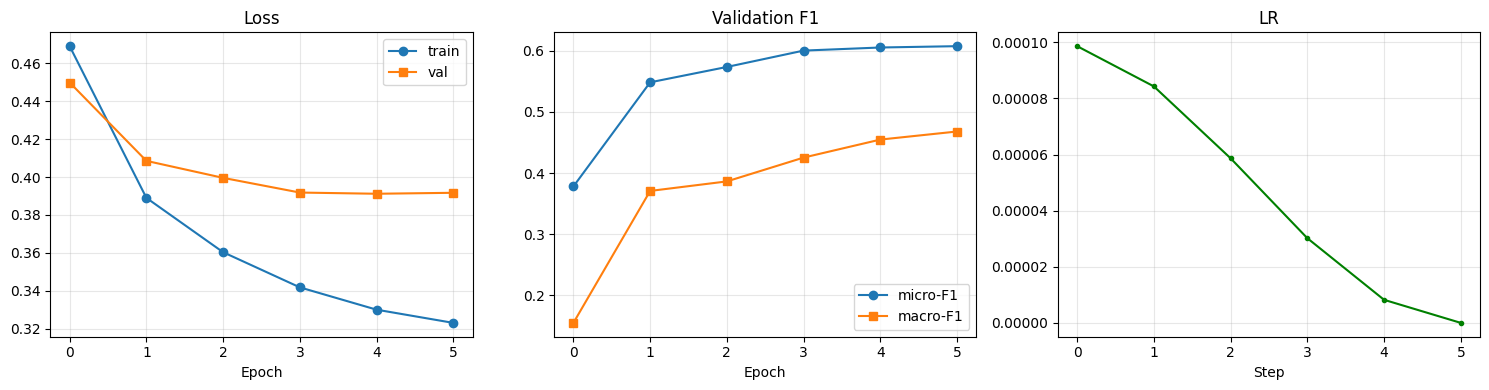


Overfitting check:
  Final train loss = 0.3231
  Final val loss   = 0.3917
  Gap              = -0.0686
  Status: ⚠ Underfitting (train > val)


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
ax.plot(history["train_loss"], "o-", label="train", ms=6)
ax.plot(history["val_loss"],   "s-", label="val",   ms=6)
ax.set_title("Loss"); ax.set_xlabel("Epoch"); ax.legend(); ax.grid(alpha=0.3)

ax = axes[1]
ax.plot(history["val_micro_f1"], "o-", label="micro-F1", ms=6)
ax.plot(history["val_macro_f1"], "s-", label="macro-F1", ms=6)
ax.set_title("Validation F1"); ax.set_xlabel("Epoch"); ax.legend(); ax.grid(alpha=0.3)

ax = axes[2]
ax.plot(history["lr"], ".-", color="green")
ax.set_title("LR"); ax.set_xlabel("Step"); ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("./curves.png", dpi=120, bbox_inches="tight")
plt.show()

# Check overfitting
final_gap = history["train_loss"][-1] - history["val_loss"][-1]
print(f"\nOverfitting check:")
print(f"  Final train loss = {history['train_loss'][-1]:.4f}")
print(f"  Final val loss   = {history['val_loss'][-1]:.4f}")
print(f"  Gap              = {final_gap:.4f}")
if abs(final_gap) < 0.05:
    print(f"  Status: Well-generalized (gap < 0.05)")
elif final_gap < 0:
    print(f"  Status: Warning: Underfitting (train > val)")
else:
    print(f"  Status: Warning: Slight overfitting (train < val)")

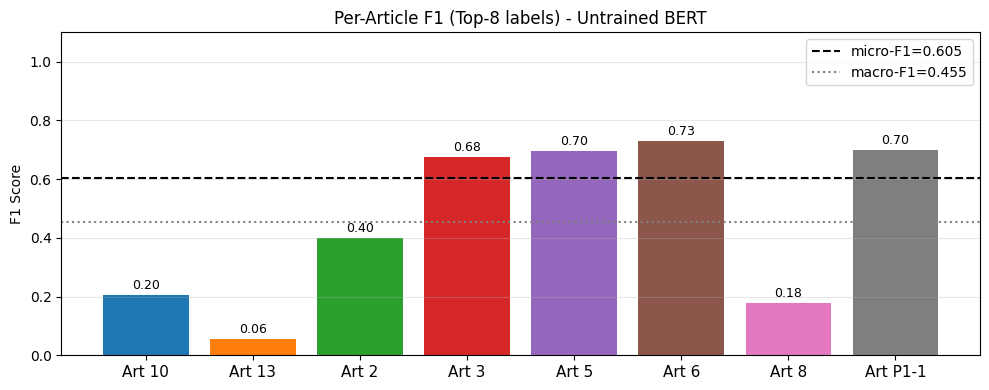


Article           F1   Precision    Recall
------------------------------------------------
  Art 10        0.2041      0.7143    0.1190
  Art 13        0.0556      0.1500    0.0341
  Art 2         0.4000      0.6957    0.2807
  Art 3         0.6767      0.6553    0.6995
  Art 5         0.6961      0.7200    0.6738
  Art 6         0.7296      0.8008    0.6700
  Art 8         0.1778      0.2500    0.1379
  Art P1-1      0.6984      0.7788    0.6331

  Micro-F1  : 0.6054
  Macro-F1  : 0.4548


In [ ]:
ckpt = torch.load(CKPT_DIR / "best_model.pt", map_location=DEVICE, weights_only=False)
model.load_state_dict(ckpt["model_state"])

val_m = evaluate(val_loader)
plf1  = val_m["per_label_f1"]

fig, ax = plt.subplots(figsize=(10, 4))
bars = ax.bar(range(NUM_LABELS), plf1, color=plt.cm.tab10(np.arange(NUM_LABELS)))
ax.set_xticks(range(NUM_LABELS))
ax.set_xticklabels([f"Art {top_labels[i]}" for i in range(NUM_LABELS)], fontsize=11)
ax.set_ylabel("F1 Score")
ax.set_title(f"Per-Article F1 (Top-{NUM_LABELS} labels) - Untrained BERT")
ax.axhline(val_m["micro_f1"], color="black", ls="--", lw=1.5,
           label=f"micro-F1={val_m['micro_f1']:.3f}")
ax.axhline(val_m["macro_f1"], color="gray",  ls=":",  lw=1.5,
           label=f"macro-F1={val_m['macro_f1']:.3f}")
for i, v in enumerate(plf1):
    ax.text(i, v+0.02, f"{v:.2f}", ha="center", fontsize=9)
ax.set_ylim(0, 1.1)
ax.legend()
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("./per_label.png", dpi=120, bbox_inches="tight")
plt.show()

print(f"\n{'Article':<12}  {'F1':>6}  {'Precision':>10}  {'Recall':>8}")
print("-" * 48)
# Recompute per-label precision/recall
val_logits, val_labels_list = [], []
for batch in val_loader:
    with torch.no_grad():
        logits = model(batch["input_ids"].to(DEVICE), batch["attention_mask"].to(DEVICE))
    val_logits.append(logits.cpu().numpy())
    val_labels_list.append(batch["labels"].cpu().numpy())
val_logits_np = np.concatenate(val_logits)
val_labels_np = np.concatenate(val_labels_list)
preds = (val_logits_np > 0).astype(int)
labels_bin = (val_labels_np > 0.5).astype(int)

for i, lbl in enumerate(top_labels):
    p_i = precision_score(labels_bin[:, i], preds[:, i], zero_division=0)
    r_i = recall_score(labels_bin[:, i], preds[:, i], zero_division=0)
    print(f"  Art {lbl:<8s}  {plf1[i]:.4f}  {p_i:>10.4f}  {r_i:>8.4f}")
print(f"\n  Micro-F1  : {val_m['micro_f1']:.4f}")
print(f"  Macro-F1  : {val_m['macro_f1']:.4f}")

In [ ]:
test_m = evaluate(test_loader)
print(f"\nTest set results (best checkpoint):")
print(f"  Loss      = {test_m['loss']:.4f}")
print(f"  Micro-F1  = {test_m['micro_f1']:.4f}")
print(f"  Macro-F1  = {test_m['macro_f1']:.4f}")
print(f"  Sample-F1 = {test_m['sample_f1']:.4f}")
print(f"  Precision = {test_m['micro_prec']:.4f}")
print(f"  Recall    = {test_m['micro_rec']:.4f}")


Test set results (best checkpoint):
  Loss      = 0.4094
  Micro-F1  = 0.5685
  Macro-F1  = 0.4614
  Sample-F1 = 0.5065
  Precision = 0.6643
  Recall    = 0.4968


In [ ]:
for p in sorted(CKPT_DIR.glob("*.pt")):
    print(f"  {p.name}  [{p.stat().st_size/1e6:.1f} MB]")
print("Model saved. Copy files from", CKPT_DIR, "as needed.")